_Lambda School Data Science — Tree Ensembles_ 

# Decision Trees Assignment

## Part 1: House Price Regression

Apply decision trees to the Ames housing dataset you've worked with this week!

- Try multiple features
- Try features you've engineered
- Try different `max_depth` paramaters
- What's the best Test Root Mean Squared Error you can get? *Share with your cohort on Slack!*
- What's a cool visualization you can make? *Share with your cohort on Slack!*

In [0]:
import graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.impute import SimpleImputer

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')

In [0]:
df['ExterQual'] = df['ExterQual'].replace({'Ex': 4, 'Gd': 3, 'TA':2, 'Fa':1, 'Po':0})
df['ExterCond'] = df['ExterCond'].replace({'Ex': 4, 'Gd': 3, 'TA':2, 'Fa':1, 'Po':0})
df['BsmtQual'] = df['BsmtQual'].replace({'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0})
df['BsmtCond'] = df['BsmtCond'].replace({'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0})
df['BsmtFinType1'] = df['BsmtFinType1'].replace({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec':3, 'LwQ':2, 'Unf':1, np.nan:0})
df['BsmtFinType2'] = df['BsmtFinType2'].replace({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec':3, 'LwQ':2, 'Unf':1, np.nan:0})
df['HeatingQC'] = df['HeatingQC'].replace({'Ex': 4, 'Gd': 3, 'TA':2, 'Fa':1, 'Po':0})
df['CentralAir'] = df['ExterQual'].replace({'No':0, 'Yes':1})
df['KitchenQual'] = df['KitchenQual'].replace({'Ex': 4, 'Gd': 3, 'TA':2, 'Fa':1, 'Po':0})
df['FireplaceQu'] = df['FireplaceQu'].replace({'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0})
df['GarageQual'] = df['GarageQual'].replace({'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0})
df['GarageCond'] = df['GarageCond'].replace({'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0})
df['PoolQC'] = df['PoolQC'].replace({'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, np.nan:0})

In [0]:
# get rid of nulls in Garage year built feature
df['GarageYrBlt'] = df['GarageYrBlt'].replace(np.nan,df['YearBuilt'])

In [0]:
## log linear of price
df['ln_price'] = np.log(df['SalePrice'])

In [0]:
df_test = df

## features engineered
df_test['GarageCars_Squared'] = df_test['GarageCars']**2
df_test['BsmtFinSF1_Squared'] = df_test['BsmtFinSF1']**2
df_test['BsmtQual_Squared'] = df_test['BsmtQual']**2
df_test['GarageYrBlt_Squared'] = df_test['GarageYrBlt']**2
df_test['age_at_time_sold'] = df_test['YrSold'] - df_test['YearBuilt']
df_test['total_area'] = (
    df_test['GarageArea'] + df_test['GrLivArea'] +df_test['TotalBsmtSF']
                        )
df_test['size_yard'] = df_test['LotArea'] - df_test['GrLivArea']
df_test['yard_int_liv'] = df_test['size_yard'] * df_test['GrLivArea']
df_test['qual_garage_int_bsmt'] = df_test['GarageQual'] * df_test['BsmtQual']
df_test['qual_exter_int_kitchen'] = df_test['ExterQual'] * df_test['KitchenQual']
df_test['total_rooms_bathrooms'] = df_test['TotRmsAbvGrd'] + df_test['FullBath']
df_test['Remodeled'] = (df_test['YearRemodAdd'] != df_test['YearBuilt']) * 1
df_test['RecentRemodel'] = (df_test['YearRemodAdd'] == df_test['YrSold']) * 1

In [0]:
## function to visualize decision tree
def viztree(decision_tree, feature_names):
    """Visualize a decision tree"""
    dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, 
                               filled=True, rounded=True)   
    return graphviz.Source(dot_data)

In [0]:
def run_decision_tree_model(X, y, features, max_depth=1):
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, test_size=.20, random_state=42)
  
  tree = DecisionTreeRegressor(max_depth=max_depth)
  tree.fit(X_train, y_train)
  
  print('Train R^2 Score: ', tree.score(X_train, y_train))
  print('Test R^2 Score: ', tree.score(X_test, y_test))
  display(viztree(tree, feature_names=features))

Train R^2 Score:  0.8044993479007602
Test R^2 Score:  0.782080670300658


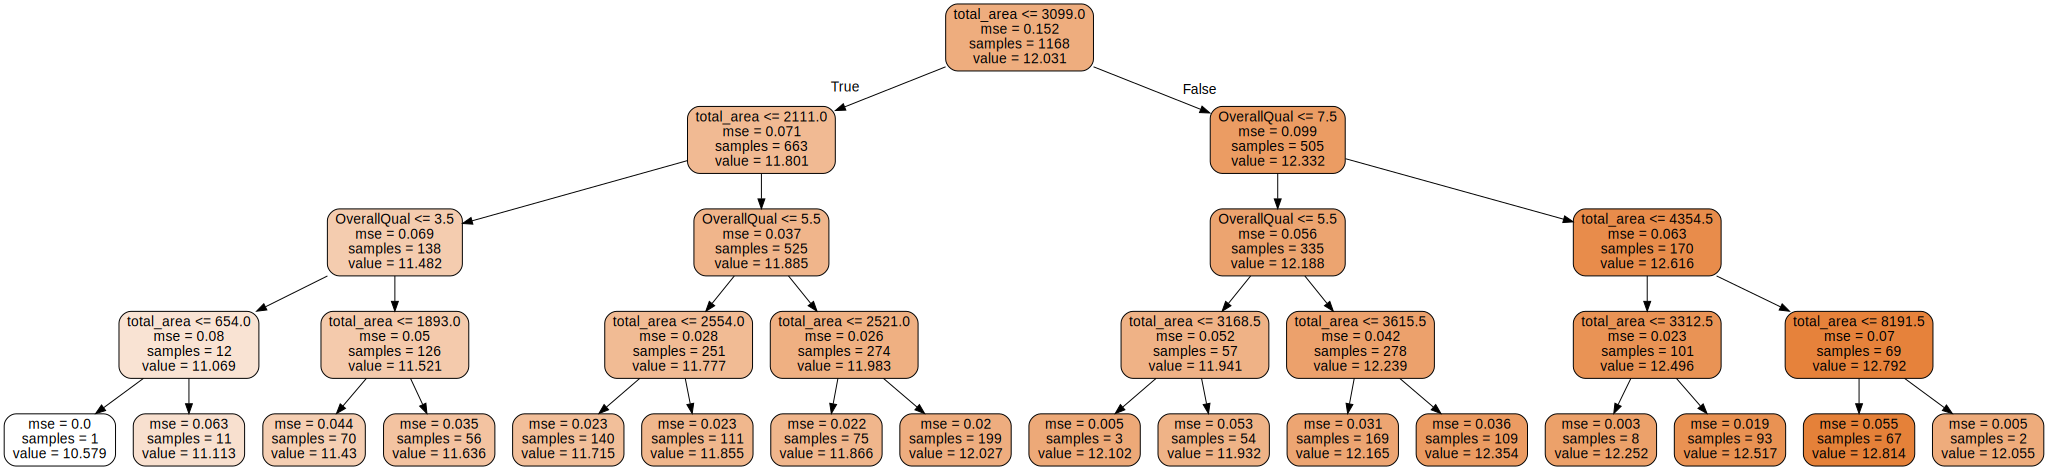

In [21]:
target = 'ln_price'
features = ['total_area', 'OverallQual']

y = df_test[target]
X = df_test[features]
run_decision_tree_model(X, y, features, 4)

## Part 2 / Stretch: "Play Tennis" Classification

We'll reproduce the "Play Tennis" example from Ross Quinlan's 1986 paper, [Induction of Decison Trees](https://link.springer.com/content/pdf/10.1007%2FBF00116251.pdf).

[According to Wikipedia](https://en.wikipedia.org/wiki/Ross_Quinlan), "John Ross Quinlan is a computer science researcher in data mining and decision theory. He has contributed extensively to the development of decision tree algorithms, including inventing the canonical C4.5 and ID3 algorithms."

#### "Table 1 shows a small training set"

In [23]:
import pandas as pd

columns = 'No. Outlook Temperature Humidity Windy PlayTennis'.split()

raw = """1 sunny hot high false N
2 sunny hot high true N
3 overcast hot high false P
4 rain mild high false P
5 rain cool normal false P
6 rain cool normal true N
7 overcast cool normal true P
8 sunny mild high false N
9 sunny cool normal false P
10 rain mild normal false P
11 sunny mild normal true P
12 overcast mild high true P
13 overcast hot normal false P
14 rain mild high true N"""

data = [row.split() for row in raw.split('\n')]
tennis = pd.DataFrame(data=data, columns=columns).set_index('No.')
tennis['PlayTennis'] = (tennis['PlayTennis'] == 'P').astype(int)

tennis

,Outlook,Temperature,Humidity,Windy,PlayTennis
No.,,,,,
1,sunny,hot,high,false,0
2,sunny,hot,high,true,0
3,overcast,hot,high,false,1
4,rain,mild,high,false,1
5,rain,cool,normal,false,1
6,rain,cool,normal,true,0
7,overcast,cool,normal,true,1
8,sunny,mild,high,false,0
9,sunny,cool,normal,false,1


#### "A decision tree that correctly classifies each object in the training set is given in Figure 2."

<img src="https://i.imgur.com/RD7d0u0.png" height="300">

In this dataset, the tennis player decided to play on 64% of the days, and decided not to on 36% of the days.

In [24]:
tennis['PlayTennis'].value_counts(normalize=True) * 100

1    64.285714
0    35.714286
Name: PlayTennis, dtype: float64

The tennis player played on 100% of the overcast days, 40% of the sunny days, and 60% of the  rainy days

In [25]:
tennis.groupby('Outlook')['PlayTennis'].mean() * 100

Outlook
overcast    100.0
rain         60.0
sunny        40.0
Name: PlayTennis, dtype: float64

On sunny days, the tennis player's decision depends on the humidity. (The Outlook and Humidity features interact.)

In [26]:
sunny = tennis[tennis['Outlook']=='sunny']
sunny.groupby('Humidity')['PlayTennis'].mean() * 100

Humidity
high        0
normal    100
Name: PlayTennis, dtype: int64

On rainy days, the tennis player's decision depends on the wind. (The Outlook and Windy features interact.)

In [27]:
rainy = tennis[tennis['Outlook']=='rain']
rainy.groupby('Windy')['PlayTennis'].mean() * 100

Windy
false    100
true       0
Name: PlayTennis, dtype: int64

#### Before modeling, we will ["encode" categorical variables, using pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html?highlight=get_dummies#computing-indicator-dummy-variables)

In [28]:
y = tennis['PlayTennis']
X = pd.get_dummies(tennis.drop(columns='PlayTennis'))
X

,Outlook_overcast,Outlook_rain,Outlook_sunny,Temperature_cool,Temperature_hot,Temperature_mild,Humidity_high,Humidity_normal,Windy_false,Windy_true
No.,,,,,,,,,,
1,0,0,1,0,1,0,1,0,1,0
2,0,0,1,0,1,0,1,0,0,1
3,1,0,0,0,1,0,1,0,1,0
4,0,1,0,0,0,1,1,0,1,0
5,0,1,0,1,0,0,0,1,1,0
6,0,1,0,1,0,0,0,1,0,1
7,1,0,0,1,0,0,0,1,0,1
8,0,0,1,0,0,1,1,0,1,0
9,0,0,1,1,0,0,0,1,1,0


## Train a Decision Tree Classifier
Get a score of 100% (accuracy)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [0]:
def classifier_decision_tree_model(X, y, features, max_depth=1):
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, test_size=.20, random_state=42)
  
  tree = DecisionTreeClassifier(max_depth=max_depth)
  tree.fit(X_train, y_train)
  
  print('Train Accuracy Score: ', tree.score(X_train, y_train))
  print('Test Accuracy Score: ', tree.score(X_test, y_test))
  display(viztree(tree, feature_names=features))

Train Accuracy Score:  1.0
Test Accuracy Score:  1.0


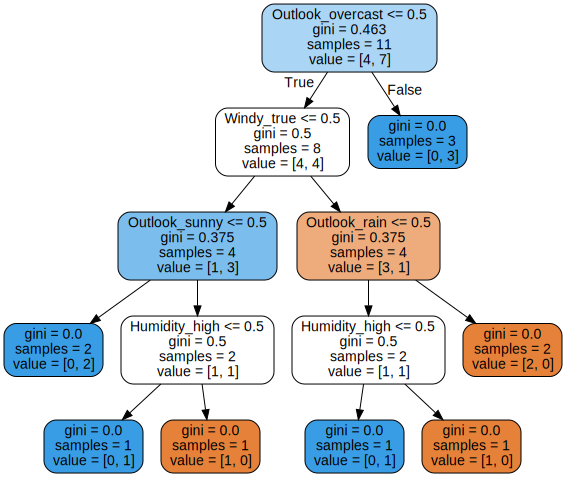

In [39]:
features = X.columns
classifier_decision_tree_model(X, y, features, 4)

## Compare to Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [47]:
def logistic_regression(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, test_size=.20, random_state=42)
  
  model = LogisticRegression()
  model.fit(X_train, y_train)
  
  print('Train Accuracy Score: ', model.score(X_train, y_train))
  print('Test Accuracy Score: ', model.score(X_test, y_test))
  
logistic_regression(X,y)

Train Accuracy Score:  0.8181818181818182
Test Accuracy Score:  0.3333333333333333


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Visualize the tree
https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

In [0]:
## ^^